# Streamline model applied to the found envelope components in B5 ALMA H$_2$CO data

What have we done up to now?

- The parameters of the DBSCAN are already good enough to separate the envelope components and other, filtered out groups of things that are harder to interpret. Due to the missing scales, these parts are deeply affected and noisy, so we limit our analysis to the envelope. We need to tune the parameters of the DBSCAN further to see if we recover more, small pixels from the envelope
- We have a skeleton with adequate parameters for the mask in physical units, but the pruning parameters are in pixels. These parameters work well for the first results from DBSCAN for the blueshifted envelope.

To do:
- We need to plot the family of streamline models that best describes the motions we are looking at. For now, limit to varying just one parameter at a time but later we can use some simulation to have a family with a range of parameters at the same time.
- Determine if there is any streamline model that can be applied to the spine found through filfinder.

## Setup

### imports

In [1]:
import numpy as np
import astropy.units as u
from astropy.io import fits
from astropy.coordinates import SkyCoord, FK5
import pyspeckit
import os
import sys
sys.path.append('../../../')
from B5setup import *
from astropy.wcs import WCS
import velocity_tools.stream_lines as SL
import velocity_tools.coordinate_offsets as c_offset
# from fil_finder import FilFinder2D
from skimage.morphology import skeletonize_3d, skeletonize, area_closing, dilation, opening
from crispy import grid_ridge
import matplotlib.pyplot as plt
from astropy.constants import k_B, m_p

%matplotlib widget

### State variables

In [2]:
run_skeletonize_blue = False
run_SL_model_blue = True
run_SL_model_skel_blue = False
run_skeletonize_red = False
run_SL_model_red = True
run_SL_model_skel_red = False

### Filename definitions

In [3]:
blue_env_paramsfile = 'components_blueshifted_envelope.fits'
red_env_paramsfile = 'components_redshifted_envelope.fits'

cubenormalfile = '../B5IRS1_H2COa_robust05_multi_3_cut_K_contcorrected.fits'
mask2dfile = '../B5IRS1_H2COa_robust05_multi_3_cut_K_contcorrected_mask.fits'

# Files for the blueshifted envelope
paramcubename_blue = 'components_blueshifted_envelope'
envelope_blue_cube_file = 'simcube_blueshifted_envelope_threshmask.fits'
skeleton_envelope_blue_cube_file = 'simcube_blueshifted_envelope_skeleton3d.fits'
spine_envelope_blue_cube_file = 'simcube_blueshifted_envelope_spine3d.fits'
spine_coordinates_file = paramcubename_blue +'_spine_coords_vel.npy'
kde_blue_file = paramcubename_blue +'_kde.npy'
kde_sigma_blue_file = paramcubename_blue +'_kde_sigma_nt.npy'
sl_model_init_result_file_blue = paramcubename_blue +'_sl_model_res.npy'

paramflagname_blue = paramcubename_blue + '_flag_repeated.fits'
imagename_blue = paramcubename_blue + '_Tpeak.fits'
vcname_blue = paramcubename_blue + '_vlsr.fits'
sigmaname_blue = paramcubename_blue + '_sigmav.fits'
sigmaname_nt_blue = paramcubename_blue + '_sigmav_nt.fits'
machvelname_blue = paramcubename_blue + '_Mach_nt.fits'

#Files for the redshifted envelope
paramcubename_red = 'components_redshifted_envelope'
envelope_red_cube_file = 'simcube_redshifted_envelope_threshmask.fits'
skeleton_envelope_red_cube_file = 'simcube_redshifted_envelope_skeleton3d.fits'
spine_envelope_red_cube_file = 'simcube_redshifted_envelope_spine3d.fits'
kde_red_file = paramcubename_red + '_kde.npy'
kde_sigma_red_file = paramcubename_red + '_kde_sigma_nt.npy'
sl_model_init_result_file_red = paramcubename_red + '_sl_model_res.npy'
sl_tinymodel_init_result_file_red = paramcubename_red + '_sl_tinymodel_res.npy'

paramflagname_red = paramcubename_red + '_flag_repeated.fits'
imagename_red = paramcubename_red + '_Tpeak.fits'
vcname_red = paramcubename_red + '_vlsr.fits'
sigmaname_red = paramcubename_red + '_sigmav.fits'
sigmaname_nt_red = paramcubename_red + '_sigmav_nt.fits'
machvelname_red = paramcubename_red + '_Mach_nt.fits'

### File loading and constants

First, we load the parameters and filenames for the envelope properties

In [4]:
# Load the parameter datacubes and wcs for 3D
blue_env_params = fits.getdata(blue_env_paramsfile)
blue_env_head = fits.getheader(blue_env_paramsfile)
red_env_params = fits.getdata(red_env_paramsfile)
red_env_head = fits.getheader(red_env_paramsfile)
mask2d = fits.getdata(mask2dfile)
cubeheader = fits.getheader(cubenormalfile)
wcshead = WCS(cubeheader)
wcs = wcshead.celestial
header_image = fits.getheader(paramflagname_blue)

'obsfix' made the change 'Set OBSGEO-L to   -67.754929 from OBSGEO-[XYZ].
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'.


We load the reference plane and constants for the streamline models

In [5]:
# Constants
if run_SL_model_blue or run_SL_model_skel_blue:
    # these properties are common between the blue and the red streamers
    M_star = 0.2 * u.Msun # from our PV diagram analysis
    M_disk = 0.032 * u.Msun # corrected from 240 to 302 pc distance from Zapata et al 2014
    M_env = 0.33 * u.Msun # corrected from 240 to 302 pc distance from Brassfield and Bourke 2011
    Mtot = M_star + M_disk + M_env
    v_lsr = 10.2 * u.km/u.s
    # inclination and position angle given by the outflow (i=0 is edge on for this setup
    # PA=0 lays on west)
    inc = (13) * u.deg
    PA_ang = (157+90)*u.deg
    
    B5_c = SkyCoord(ra_yso*u.deg, dec_yso*u.deg, frame='fk5')
    B5_ref = B5_c.skyoffset_frame()
    # axes given by i and PA
    x_b = np.array([1, 0, 0])*1e3/dist_B5.value
    y_b = np.array([0, 0, 0])*1e3/dist_B5.value
    z_b = np.array([0, 0, 1])*1e3/dist_B5.value
    nx_b, ny_b, nz_b = SL.rotate_xyz(x_b, y_b, z_b, inc=inc, pa=PA_ang)
    my_axis_new = SkyCoord(-nx_b*u.arcsec, nz_b*u.arcsec, frame=B5_ref).transform_to(FK5)
    if ny_b[-1] > 0:
        new_ax_color = 'red'
    else:
        new_ax_color = 'blue'

We open the files and create individual files for parameter images if they do not exist

In [6]:
if not os.path.exists(imagename_blue) or not os.path.exists(vcname_blue) or not os.path.exists(sigmaname_blue):
    paramcube_blue = fits.getdata(paramcubename_blue+'.fits')
    Tpeak_blue = paramcube_blue[0]
    if not os.path.exists(imagename_blue): fits.writeto(imagename_blue, Tpeak_blue, header_image)
    v_cent_blue = paramcube_blue[1]
    if not os.path.exists(vcname_blue): fits.writeto(vcname_blue, v_cent_blue, header_image)
    sigmav_blue = paramcube_blue[2]
    if not os.path.exists(sigmaname_blue): fits.writeto(sigmaname_blue, sigmav_blue, header_image)

else:
    Tpeak_blue = fits.getdata(imagename_blue)
    v_cent_blue = fits.getdata(vcname_blue) 
    sigmav_blue = fits.getdata(sigmaname_blue) 
    
if not os.path.exists(imagename_red) or not os.path.exists(vcname_red) or not os.path.exists(sigmaname_red):
    paramcube_red = fits.getdata(paramcubename_red+'.fits')
    Tpeak_red = paramcube_red[0]
    if not os.path.exists(imagename_red): fits.writeto(imagename_red, Tpeak_red, header_image)
    v_cent_red = paramcube_red[1]
    if not os.path.exists(vcname_red): fits.writeto(vcname_red, v_cent_red, header_image)
    sigmav_red = paramcube_red[2]
    if not os.path.exists(sigmaname_red): fits.writeto(sigmaname_red, sigmav_red, header_image)

else:
    Tpeak_red = fits.getdata(imagename_red)
    v_cent_red = fits.getdata(vcname_red) 
    sigmav_red = fits.getdata(sigmaname_red) 
    
    
# in particular, for further analysis, we must deconvolve the fitted dispersion and find the non-thermal 
# dispersion to see if it is subsonic or not
sigmav_bluedec = np.sqrt(sigmav_blue**2 - (cubeheader['CDELT3']/2.355 * 2) **2)
sigmav_reddec = np.sqrt(sigmav_red**2 - (cubeheader['CDELT3']/2.355 * 2) **2)

# these are common for all
thermalsigma = np.sqrt(k_B * 9.7 * u.K / (30.026 * m_p)).to(u.km/u.s).value
soundspeed = np.sqrt(k_B * 9.7 * u.K / (2.37 * m_p)).to(u.km/u.s).value
print(r'Thermal $\sigma$ = '+str(thermalsigma) + r' km/s')
print(r'$c_s$'+str(soundspeed) + r' km/s')

sigma_nt_blue = np.sqrt(sigmav_bluedec**2 - thermalsigma**2)
sigma_nt_red = np.sqrt(sigmav_reddec**2 - thermalsigma**2)

if not os.path.exists(sigmaname_nt_blue): fits.writeto(sigmaname_nt_blue, sigma_nt_blue, header_image)
if not os.path.exists(sigmaname_nt_red): fits.writeto(sigmaname_nt_red, sigma_nt_red, header_image)

Mach_sigmant_blue = sigma_nt_blue/soundspeed
Mach_sigmant_red = sigma_nt_red/soundspeed
if not os.path.exists(machvelname_blue): fits.writeto(machvelname_blue, Mach_sigmant_blue, header_image)
if not os.path.exists(machvelname_red): fits.writeto(machvelname_red, Mach_sigmant_red, header_image)


Thermal $\sigma$ = 0.05163924403674424 km/s
$c_s$0.183803781865192 km/s


invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt


We create the Kernel Density Estimate for the velocities and dispersions

In [7]:
if run_SL_model_blue or run_SL_model_skel_blue:
    # Here we obtain the kernel density estimation of the velocities along the line of sight
    r_proj, v_los = get_vc_r(vcname_blue, ra_yso*u.deg, dec_yso*u.deg, dist_B5.value)
    # and also for the non-thermal velocity dispersion
    r_proj_sigma, sigma_los = get_vc_r(sigmaname_nt_blue, ra_yso*u.deg, dec_yso*u.deg, dist_B5.value)
    # create the grid for the kernel distribution
    # x is projected distance
    xmin = 0
    xmax = 1600
    # y is velocity lsr
    ymin = 9
    ymax = 10.5
    #y2 is sigma
    y2min = 0
    y2max = 0.4
    xx_blue, yy_blue = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    xx_blue2, yy_blue2 = np.mgrid[xmin:xmax:100j, y2min:y2max:100j]
    positions = np.vstack([xx_blue.ravel(), yy_blue.ravel()])
    positions2 = np.vstack([xx_blue2.ravel(), yy_blue2.ravel()])
    # we select only those who are not nan
    gd_vlos = np.isfinite(r_proj*v_los)
    gd_sigma = np.isfinite(r_proj_sigma*sigma_los)
    # we do the kde for the velocities and sigma_v
    values = np.vstack([r_proj[gd_vlos].value, v_los[gd_vlos].value])
    values_sigma = np.vstack([r_proj_sigma[gd_sigma].value, sigma_los[gd_sigma].value])
    # we calculate the kernel distribution
    kernel = stats.gaussian_kde(values)
    kernel2 = stats.gaussian_kde(values_sigma)
    
    zz_blue = np.reshape(kernel(positions).T, xx_blue.shape)
    zz_blue /= zz_blue.max()  # normalization of probability
    if not os.path.exists(kde_blue_file):
        kde_data = np.array([xx_blue, yy_blue, zz_blue])
        np.save(kde_blue_file, kde_data)
    
    zz_blue2 = np.reshape(kernel2(positions2).T, xx_blue2.shape)
    zz_blue2 /= zz_blue2.max()
    if not os.path.exists(kde_sigma_blue_file):
        kde_data2 = np.array([xx_blue2, yy_blue2, zz_blue2])
        np.save(kde_sigma_blue_file, kde_data2)

'obsfix' made the change 'Set OBSGEO-L to   -67.754929 from OBSGEO-[XYZ].
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'.


In [8]:
if run_SL_model_red or run_SL_model_skel_red:
    # Here we obtain the kernel density estimation of the velocities along the line of sight
    r_proj, v_los = get_vc_r(vcname_red, ra_yso*u.deg, dec_yso*u.deg, dist_B5.value)
    # and also for the non-thermal velocity dispersion
    r_proj_sigma, sigma_los = get_vc_r(sigmaname_nt_red, ra_yso*u.deg, dec_yso*u.deg, dist_B5.value)
    # create the grid for the kernel distribution
    # x is projected distance
    xmin = 0
    xmax = 1600
    # y is velocity lsr
    ymin = 10
    ymax = 10.7
    #y2 is sigma
    y2min = 0
    y2max = 0.6
    xx_red, yy_red = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    xx_red2, yy_red2 = np.mgrid[xmin:xmax:100j, y2min:y2max:100j]
    positions = np.vstack([xx_red.ravel(), yy_red.ravel()])
    positions2 = np.vstack([xx_red2.ravel(), yy_red2.ravel()])
    # we select only those who are not nan
    gd_vlos = np.isfinite(r_proj*v_los)
    gd_sigma = np.isfinite(r_proj_sigma*sigma_los)
    # we do the kde for the velocities and sigma_v
    values = np.vstack([r_proj[gd_vlos].value, v_los[gd_vlos].value])
    values_sigma = np.vstack([r_proj_sigma[gd_sigma].value, sigma_los[gd_sigma].value])
    # we calculate the kernel distribution
    kernel = stats.gaussian_kde(values)
    kernel2 = stats.gaussian_kde(values_sigma)
    
    zz_red = np.reshape(kernel(positions).T, xx_red.shape)
    zz_red /= zz_red.max()  # normalization of probability
    if not os.path.exists(kde_red_file):
        kde_data = np.array([xx_red, yy_red, zz_red])
        np.save(kde_red_file, kde_data)
    
    zz_red2 = np.reshape(kernel2(positions2).T, xx_red2.shape)
    zz_red2 /= zz_red2.max()
    if not os.path.exists(kde_sigma_red_file):
        kde_data2 = np.array([xx_red2, yy_red2, zz_red2])
        np.save(kde_sigma_red_file, kde_data2)

### Functions for streamlines

In [9]:
def get_streamer(mass, r0, theta0, phi0, omega0, v_r0, inc, PA, rmin=250):
    (x1, y1, z1), (vx1, vy1, vz1) = SL.xyz_stream(
        mass=mass, r0=r0, theta0=theta0, phi0=phi0,
        omega=omega0, v_r0=v_r0, inc=inc, pa=PA, rmin=rmin*u.au) #, deltar=10*u.au)
    # we obtain the distance of each point in the sky
    d_sky_au = np.sqrt(x1**2 + z1**2)
    # Stream line into arcsec
    dra_stream = -x1.value / dist_B5.value
    ddec_stream = z1.value / dist_B5.value
    fil = SkyCoord(dra_stream*u.arcsec, ddec_stream*u.arcsec,
                   frame=B5_ref).transform_to(FK5)
    velocity = v_lsr + vy1
    return fil, d_sky_au, velocity

def plot_image_and_KDE(fig, data, kdedata, wcs, intmin=0, intmax=10, velmin=9, 
                       velmax=11, xmin=0, xmax=2000, regionplot=None, velobject=10.2, 
                       axis_new=None, new_ax_color='red', cmap='Greys'):
    ax1 = fig.add_subplot(121, projection=wcs)
    imageplane = ax1.imshow(data, vmin=intmin, vmax=intmax, origin='lower', cmap=cmap)
    fig.colorbar(imageplane, ax=ax1)
    ax1.set_autoscale_on(False)
    ax1.plot(ra_yso, dec_yso, transform=ax1.get_transform('fk5'), marker='*', color='red')
    ax1.set_xlabel('Right Ascension (J2000)')
    ax1.set_ylabel('Declination (J2000)')
    if regionplot is not None:
        patch_list, artist_list = regionplot.get_mpl_patches_texts()
        for p in patch_list:
            ax1.add_patch(p)
        for a in artist_list:
            ax1.add_artist(a)
    if axis_new is not None:
        ax1.plot(axis_new.ra[1:], axis_new.dec[1:], transform=ax1.get_transform('fk5'), color=new_ax_color)
        ax1.plot(axis_new.ra[0:2], axis_new.dec[0:2], transform=ax1.get_transform('fk5'), color='red')
    
    ax2 = fig.add_subplot(122)
    ax2.set_xlabel('Projected distance (au)')
    ax2.set_ylabel(r"V$_{lsr}$ (km s$^{-1}$)")
    xx, yy, zz = kdedata
    ax2.contourf(xx, yy, zz, cmap='Greys', levels=np.arange(0.1, 1.2, 0.1), vmin=0., vmax=1.1)
    ax2.axhline(velobject, color='k', ls=':')
    ax2.set_ylim([velmin,velmax])
    ax2.set_xlim([xmin,xmax])
    
    return ax1, ax2


We plot to see that the image and KDE worked as expected

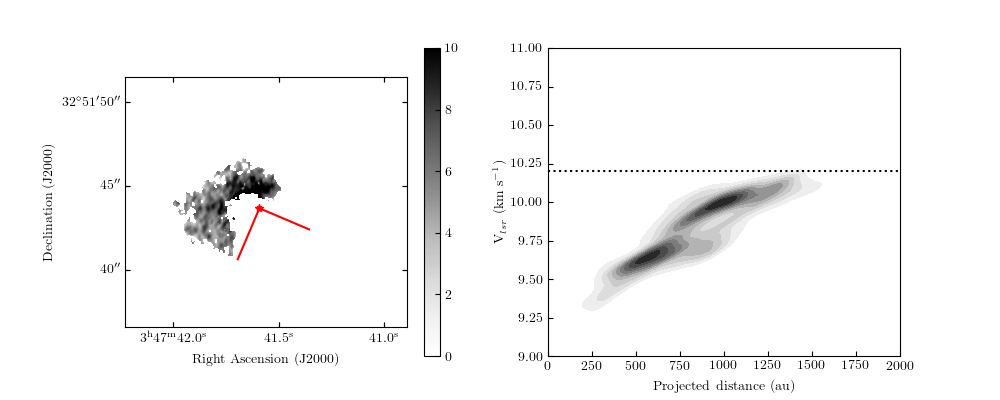

In [10]:
# initial plot: without streamline model
if run_SL_model_blue:
    fig = plt.figure(figsize=(10,4))
    ax1, ax2 = plot_image_and_KDE(fig, Tpeak_blue, (xx_blue, yy_blue, zz_blue), wcs, regionplot=None, axis_new=my_axis_new, new_ax_color=new_ax_color)


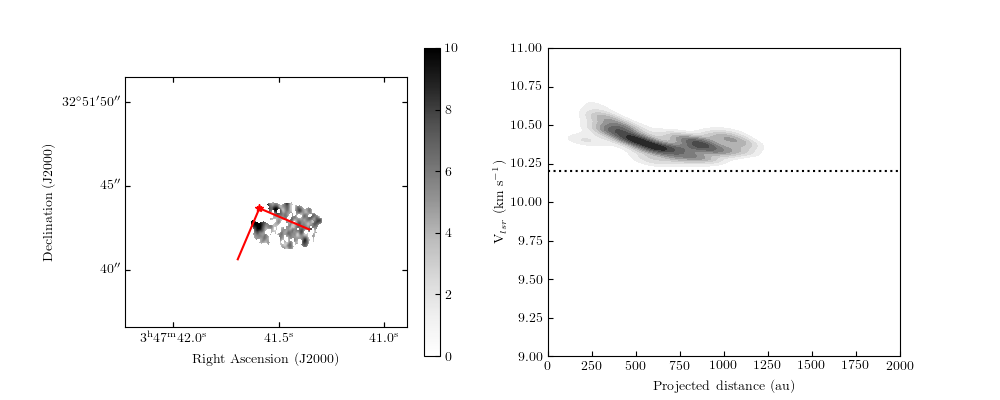

In [11]:
if run_SL_model_red:
    fig = plt.figure(figsize=(10,4))
    ax1, ax2 = plot_image_and_KDE(fig, Tpeak_red, (xx_red, yy_red, zz_red), wcs, regionplot=None, axis_new=my_axis_new, new_ax_color=new_ax_color)


### Initial parameters set from interactive streamline model

In [12]:
# Initial parameters
if run_SL_model_blue or run_SL_model_skel_blue:
    r0_blue = 2810 * u.au # was 2660 until 19.9.22
    theta0_blue = 101 * u.deg  # rotate clockwise
    phi0_blue = 65 * u.deg # was 71 until 19.9.22
    v_r0_blue = 0.0 * u.km/u.s
    omega0_blue = 2.98e-13 / u.s # was 3e-13 until 19.9.22
    r_c = SL.r_cent(Mtot,omega0_blue,r0_blue) # 248.5
    fil0_blue, dsky0_blue, velo0_blue = get_streamer(Mtot, r0_blue, theta0_blue, phi0_blue, omega0_blue, v_r0_blue, inc, PA_ang, rmin=r_c.value)
    
    
    if not os.path.exists(sl_model_init_result_file_blue):
        results_sl_model_blue = np.array([fil0_blue.ra, fil0_blue.dec, dsky0_blue, velo0_blue])
        np.save(sl_model_init_result_file_blue, results_sl_model_blue)
        

rc=248.53416295107635 AU


In [13]:
if run_SL_model_red or run_SL_model_skel_red:
    r0_red = 2810 * u.au # was 2660 until 19.9.22
    theta0_red = 22 * u.deg  # rotate clockwise, was 22 until 19.9.22
    phi0_red = 237 * u.deg # was 242 until 19.9.22
    v_r0_red = 0.0 * u.km/u.s
    omega0_red = 2.98e-13 / u.s # was 3e-13 until 19.9.22
    r_c = SL.r_cent(Mtot,omega0_red,r0_red)
    fil0_red, dsky0_red, velo0_red = get_streamer(Mtot, r0_red, theta0_red, phi0_red, omega0_red, v_r0_red, inc, PA_ang, rmin=r_c.value)
    
    
    if not os.path.exists(sl_model_init_result_file_red):
        results_sl_model_red = np.array([fil0_red.ra, fil0_red.dec, dsky0_red, velo0_red])
        np.save(sl_model_init_result_file_red, results_sl_model_red)
    

rc=248.53416295107635 AU


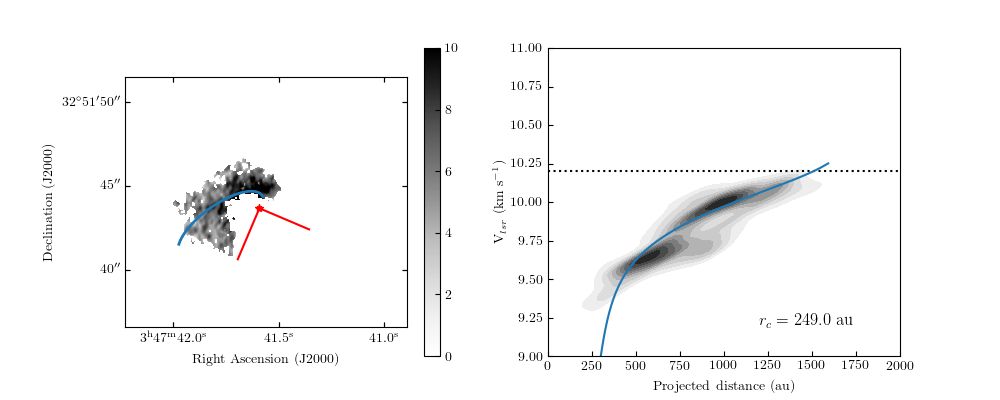

In [14]:
if run_SL_model_blue:
    fig = plt.figure(figsize=(10,4))
    ax1, ax2 = plot_image_and_KDE(fig, Tpeak_blue, (xx_blue, yy_blue, zz_blue), wcs, regionplot=None, axis_new=my_axis_new, new_ax_color=new_ax_color)

    # We add the curves from the streamline model
    line_image, = ax1.plot(fil0_blue.ra, fil0_blue.dec, transform=ax1.get_transform('fk5'), ls='-', lw=2)
    line_vel, = ax2.plot(dsky0_blue, velo0_blue)
    annotation = ax2.annotate(r'$r_c = {}$ au'.format(np.round(r_c.value,0)), (0.6, 0.1), xycoords='axes fraction', size=12)

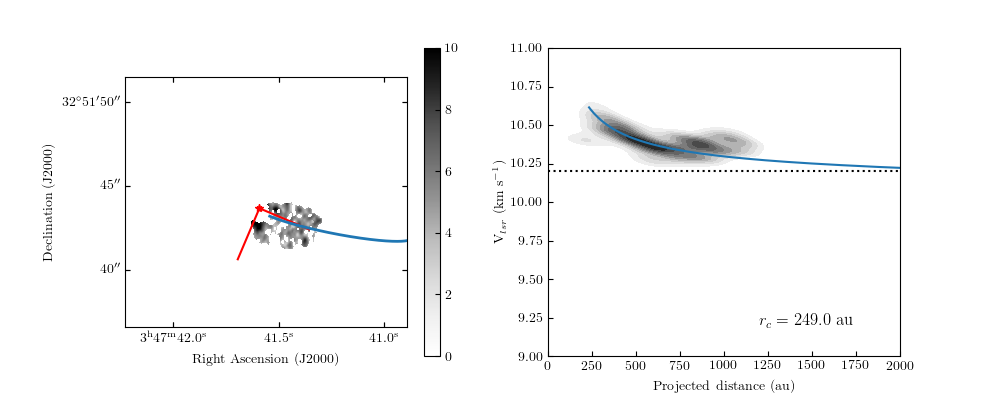

In [15]:
if run_SL_model_red:
    fig = plt.figure(figsize=(10,4))
    ax1, ax2 = plot_image_and_KDE(fig, Tpeak_red, (xx_red, yy_red, zz_red), wcs, regionplot=None, axis_new=my_axis_new, new_ax_color=new_ax_color)

    # We add the curves from the streamline model
    line_image, = ax1.plot(fil0_red.ra, fil0_red.dec, transform=ax1.get_transform('fk5'), ls='-', lw=2)
    line_vel, = ax2.plot(dsky0_red, velo0_red)
    annotation = ax2.annotate(r'$r_c = {}$ au'.format(np.round(r_c.value,0)), (0.6, 0.1), xycoords='axes fraction', size=12)

We test the possibility of a shorter streamer for the redshifted component

In [16]:
if run_SL_model_red or run_SL_model_skel_red:
    r0_red = 1050 * u.au # could also be  1010
    theta0_red = 26 * u.deg  # rotate clockwise, could be 24
    phi0_red = 288 * u.deg # could be   276
    v_r0_red = 0.1 * u.km/u.s
    omega0_red = 3.1e-13 / u.s
    r_c = SL.r_cent(Mtot,omega0_red,r0_red)
    fil0_red, dsky0_red, velo0_red = get_streamer(Mtot, r0_red, theta0_red, phi0_red, omega0_red, v_r0_red, inc, PA_ang, rmin=r_c.value)
    
    
    if not os.path.exists(sl_tinymodel_init_result_file_red):
        results_sl_tinymodel_red = np.array([fil0_red.ra, fil0_red.dec, dsky0_red, velo0_red])
        np.save(sl_tinymodel_init_result_file_red, results_sl_tinymodel_red)

rc=5.2433502671908565 AU


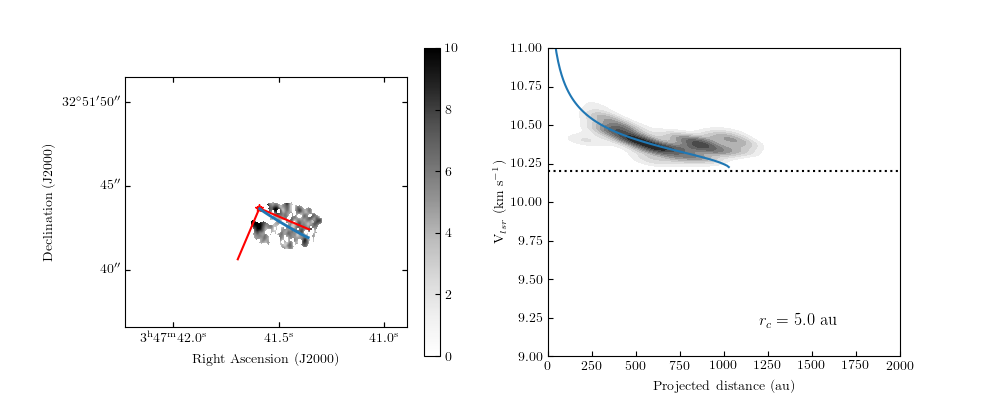

In [17]:
if run_SL_model_red:
    fig = plt.figure(figsize=(10,4))
    ax1, ax2 = plot_image_and_KDE(fig, Tpeak_red, (xx_red, yy_red, zz_red), wcs, regionplot=None, axis_new=my_axis_new, new_ax_color=new_ax_color)

    # We add the curves from the streamline model
    line_image, = ax1.plot(fil0_red.ra, fil0_red.dec, transform=ax1.get_transform('fk5'), ls='-', lw=2)
    line_vel, = ax2.plot(dsky0_red, velo0_red)
    annotation = ax2.annotate(r'$r_c = {}$ au'.format(np.round(r_c.value,0)), (0.6, 0.1), xycoords='axes fraction', size=12)

### Angular momentum

In [ ]:
rc = SL.r_cent(mass=Mtot, omega=omega0_red, r0=r0_red)
r = np.arange(r0_red.value, rc.to(u.au).value*0.5, step=-10) * u.au
theta = SL.stream_line(r, mass=Mtot, r0=r0_red, theta0=theta0_red, omega=omega0_red, v_r0=v_r0_red)

(vr, vt, vp) = SL.stream_line_vel(r, theta, mass=Mtot, r0=r0_red, theta0=theta0_red, omega=omega0_red, v_r0=v_r0_red)

rc=5.2433502671908565 AU


In [ ]:
j_tinyred_sl = (r * vp).to(u.km/u.s*u.pc)
j_tinyred_sl

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.loglog(r, j_tinyred_sl, 'r-')
ax.set_xlabel('Distance from protostar (au)')
ax.set_ylabel('Specific angular momentum (km/s pc)')
fig.tight_layout()
# ask if this diminishing is a numerical error propagation

In [ ]:
rc_blue = SL.r_cent(mass=Mtot, omega=omega0_blue, r0=r0_blue)
r_blue = np.arange(r0_red.value, rc.to(u.au).value*0.5, step=-10) * u.au
theta_blue = SL.stream_line(r, mass=Mtot, r0=r0_blue, theta0=theta0_blue, omega=omega0_blue, v_r0=v_r0_blue)

(vr_blue, vt_blue, vp_blue) = SL.stream_line_vel(r_blue, theta_blue, mass=Mtot, r0=r0_blue, theta0=theta0_blue, omega=omega0_blue, v_r0=v_r0_blue)

In [ ]:
j_blue_sl = (r_blue * vp_blue).to(u.km/u.s*u.pc)
j_blue_sl

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.loglog(r_blue, j_blue_sl)
ax.set_xlabel('Distance from protostar (au)')
ax.set_ylabel('Specific angular momentum (km/s pc)')
fig.tight_layout()
# ask if this diminishing is a numerical error propagation

### Test of the $\theta$ parameter

In [ ]:
if run_SL_model_blue:
    theta0_bluelist = np.array([96, 101, 106, 111, 116]) * u.deg  # we know that it has to be from the lower half of the sphere
    curveslist = []
    for theta in theta0_bluelist:
        fil0_blue, dsky0_blue, velo0_blue = get_streamer(Mtot, r0_blue, theta, phi0_blue, omega0_blue, v_r0_blue, inc, PA_ang)
        curveslist.append([fil0_blue, dsky0_blue, velo0_blue])
    r_c = SL.r_cent(Mtot,omega0_blue,r0_blue)

In [ ]:
if run_SL_model_blue:
    fig = plt.figure(figsize=(10,4))
    ax1, ax2 = plot_image_and_KDE(fig, Tpeak_blue, (xx_blue, yy_blue, zz_blue), wcs, regionplot=None, axis_new=my_axis_new, new_ax_color=new_ax_color)
    for i, curve in enumerate(curveslist):
        # We add the curves from the streamline model
        fil0_blue, dsky0_blue, velo0_blue = curve
        line_image, = ax1.plot(fil0_blue.ra, fil0_blue.dec, transform=ax1.get_transform('fk5'), ls='-', lw=2)
        line_vel, = ax2.plot(dsky0_blue, velo0_blue, label=str(theta0_bluelist[i]))
    annotation = ax2.annotate(r'$r_c = {}$ au'.format(np.round(r_c.value,0)), (0.6, 0.1), xycoords='axes fraction', size=12)
    ax2.annotate(r'Comparing $\vartheta_0$', (0.1, 0.9), xycoords='axes fraction', size=12)
    ax2.legend()

### Test of the $\phi$ parameter

In [ ]:
if run_SL_model_blue:
    phi0_bluelist = np.array([61, 66, 71, 76, 81]) * u.deg  # we know that it has to be from the lower half of the sphere
    curveslist = []
    for phi in phi0_bluelist:
        fil0_blue, dsky0_blue, velo0_blue = get_streamer(Mtot, r0_blue, theta0_blue, phi, omega0_blue, v_r0_blue, inc, PA_ang)
        curveslist.append([fil0_blue, dsky0_blue, velo0_blue])
    r_c = SL.r_cent(Mtot,omega0_blue,r0_blue)

In [ ]:
if run_SL_model_blue:
    fig = plt.figure(figsize=(10,4))
    ax1, ax2 = plot_image_and_KDE(fig, Tpeak_blue, (xx_blue, yy_blue, zz_blue), wcs, regionplot=None, axis_new=my_axis_new, new_ax_color=new_ax_color)
    for i, curve in enumerate(curveslist):
        # We add the curves from the streamline model
        fil0_blue, dsky0_blue, velo0_blue = curve
        line_image, = ax1.plot(fil0_blue.ra, fil0_blue.dec, transform=ax1.get_transform('fk5'), ls='-', lw=2)
        line_vel, = ax2.plot(dsky0_blue, velo0_blue, label=str(theta0_bluelist[i]))
    annotation = ax2.annotate(r'$r_c = {}$ au'.format(np.round(r_c.value,0)), (0.6, 0.1), xycoords='axes fraction', size=12)
    ax2.annotate(r'Comparing $\varphi_0$', (0.1, 0.9), xycoords='axes fraction', size=12)
    ax2.legend()

### Test of the $\Omega$ parameter

In [ ]:
if run_SL_model_blue:
    omega0_bluelist = np.array([2.3, 2.7, 3.1, 3.5, 3.9]) * 1.0e-13 / u.s
    curveslist = []
    rclist = []
    for omega in omega0_bluelist:
        fil0_blue, dsky0_blue, velo0_blue = get_streamer(Mtot, r0_blue, theta0_blue, phi0_blue, omega, v_r0_blue, inc, PA_ang)
        curveslist.append([fil0_blue, dsky0_blue, velo0_blue])
        rclist.append(SL.r_cent(Mtot,omega,r0_blue))

In [ ]:
if run_SL_model_blue:
    fig = plt.figure(figsize=(10,4))
    ax1, ax2 = plot_image_and_KDE(fig, Tpeak_blue, (xx_blue, yy_blue, zz_blue), wcs, regionplot=None, axis_new=my_axis_new, new_ax_color=new_ax_color)
    for i, curve in enumerate(curveslist):
        # We add the curves from the streamline model
        fil0_blue, dsky0_blue, velo0_blue = curve
        line_image, = ax1.plot(fil0_blue.ra, fil0_blue.dec, transform=ax1.get_transform('fk5'), ls='-', lw=2)
        line_vel, = ax2.plot(dsky0_blue, velo0_blue, label=str(omega0_bluelist[i]))
        annotation = ax2.annotate(r'$r_c = {}$ au'.format(np.round(rclist[i].value,0)), (0.6, 0.3-0.05*i), xycoords='axes fraction', size=12, color='C{}'.format(i))
    ax2.annotate(r'Comparing $\Omega_0$', (0.1, 0.9), xycoords='axes fraction', size=12)
    ax2.legend()

### Test of the r parameter

In [ ]:
if run_SL_model_blue:
    r0_bluelist = np.array([2200, 2400, 2600, 2800, 3000]) * u.au
    curveslist = []
    rclist = []
    for r in r0_bluelist:
        fil0_blue, dsky0_blue, velo0_blue = get_streamer(Mtot, r, theta0_blue, phi0_blue, omega0_blue, v_r0_blue, inc, PA_ang)
        curveslist.append([fil0_blue, dsky0_blue, velo0_blue])
        rclist.append(SL.r_cent(Mtot,omega0_blue,r))

In [ ]:
if run_SL_model_blue:
    fig = plt.figure(figsize=(10,4))
    ax1, ax2 = plot_image_and_KDE(fig, Tpeak_blue, (xx_blue, yy_blue, zz_blue), wcs, regionplot=None, axis_new=my_axis_new, new_ax_color=new_ax_color)
    for i, curve in enumerate(curveslist):
        # We add the curves from the streamline model
        fil0_blue, dsky0_blue, velo0_blue = curve
        line_image, = ax1.plot(fil0_blue.ra, fil0_blue.dec, transform=ax1.get_transform('fk5'), ls='-', lw=2)
        line_vel, = ax2.plot(dsky0_blue, velo0_blue, label=str(r0_bluelist[i]))
        annotation = ax2.annotate(r'$r_c = {}$ au'.format(np.round(rclist[i].value,0)), (0.6, 0.3-0.05*i), xycoords='axes fraction', size=12, color='C{}'.format(i))
    ax2.annotate(r'Comparing $r_0$', (0.1, 0.9), xycoords='axes fraction', size=12)
    ax2.legend()

## Skeletonize the blueshifted envelope to see if there is a main tendency for a SL model

In [ ]:
# lets try preprocessing the image
if run_skeletonize_blue:
    mask = ~np.isnan(Tpeak_blue)
    fil= FilFinder2D(Tpeak_blue, header=header_image, distance=dist_B5)#, mask=mask)
    fil.preprocess_image(flatten_percent=75)
    noise_level = np.nanpercentile(fil.image, 20)
    fig = plt.figure()
    ax = fig.add_subplot(121)
    im = ax.imshow(fil.image.value, origin='lower')
    fig.colorbar(im, ax=ax, location='top')
    ax2 = fig.add_subplot(122)
    im2 = ax2.imshow(fil.flat_img.value, origin='lower')
    fig.colorbar(im2, ax=ax2, location='top')
    # to look at the noise level
    # yy_blue, xx_blue = np.mgrid[0:np.shape(fil.image.value)[0], 0:np.shape(fil.image.value)[1]]
    # ax2.contour(xx_blue, yy_blue, (fil.image.value > noise_level).astype(int), levels=[0.5])
    # it looks like masking for noise will not help
    # if run_skeletonize:
    #     if not os.path.exists(envelope_blue_cube_file):
    #         cube = pyspeckit.Cube(filename=cubenormalfile)
    #         cube.load_model_fit(blue_env_paramsfile, npars=3, npeaks=1, fittype='gaussian')
    #         simcube = cube.get_modelcube()

    #         thresh = np.nanmin(blue_env_params[0])

    #         envelope_blue_cube = np.zeros(np.shape(simcube))
    #         envelope_blue_cube[np.where(simcube>thresh)] = 1
    #         fits.writeto(envelope_blue_cube_file, envelope_blue_cube, cubeheader)
    #     else:
    #         envelope_blue_cube = fits.getdata(envelope_blue_cube_file)

    #     # we can do the skeletons in 2d
    #     mom0_vel_envelope_blue_cube = np.where(np.sum(envelope_blue_cube, axis=0) >0, 1, 0)
    #     mom0_dec_envelope_blue_cube = np.where(np.sum(envelope_blue_cube, axis=1)>0, 1, 0)
    #     mom0_ra_envelope_blue_cube = np.where(np.sum(envelope_blue_cube, axis=2)>0, 1, 0)

    #     skeleton_vel_envelope_blue_cube = skeletonize(area_closing(dilation(mom0_vel_envelope_blue_cube)))
    #     skeleton_dec_envelope_blue_cube = skeletonize(mom0_dec_envelope_blue_cube)
    #     skeleton_ra_envelope_blue_cube = skeletonize(mom0_ra_envelope_blue_cube)

In [ ]:
if run_skeletonize_blue:
    # the ones that are now work for the first dbscan
    threshold = 6. #K after preprocessing originally 5.5 K
    adapt_thresh = 200 * u.au # originally 200 au, 200 au works good
    size_thresh = 300 * u.pix**2 # originally 10
    smooth_kernel_size = 0.0001*u.deg # basically smoothing kernel, originally 0.0001 deg2, ideally not more than that
    border_masking = False # we need the edges so this is left as false
    fill_hole_size = 50 * u.pix**2
    plt.figure()
    fil.create_mask(verbose=True, glob_thresh=threshold, adapt_thresh=adapt_thresh, size_thresh=size_thresh, smooth_size=smooth_kernel_size, border_masking=border_masking, fill_hole_size=fill_hole_size)

In [ ]:
# here we convert the mask into a skeleton
if run_skeletonize:
    plt.figure()
    fil.medskel(verbose=True)

In [ ]:
# here we prune the skeleton to find a spine
if run_skeletonize_blue:
    # the ones that are now work for the first dbscan
    branch_thresh = 20 * u.pix #100 * u.au # length of a branch, started as 10 px, 60 works well
    skel_thresh = 50 * u.pix # 300 * u.au # length of the skeleton started as 50 px. 100 works well
    max_prune_iter = 1000 # 10 is too little, 100 seemed to work ok

    fil.analyze_skeletons(branch_thresh=branch_thresh, skel_thresh=skel_thresh, prune_criteria='length', max_prune_iter=max_prune_iter)

    plt.figure()
    plt.imshow(fil.skeleton, origin='lower')
    plt.contour(fil.skeleton_longpath, colors='r')        

## Model the filament spine using the SL model

In [ ]:
# now we need to obtain the coordinates of the spine (the longest path)
if run_SL_model_skel_blue and run_skeletonize_blue:
    spine_footprint = fil.skeleton_longpath
    length_spine = fil.lengths(u.au)[0] # length in au    
    spine_coords = np.array(np.where(spine_footprint))[::-1] # x, y order
    # translate the coordinates into the original grid
    spine_coords_wcs = wcshead.celestial.all_pix2world(spine_coords.T, 0).T
    # obtain the velocities at those points
    spine_vel = np.array([v_cent_blue[y, x] for x, y in zip(spine_coords[0], spine_coords[1])])
    # obtain the distance of each pair of coordinates from the protostar
    results = c_offset.generate_offsets(header_image, ra_yso*u.deg, dec_yso*u.deg, pa_angle=0*u.deg, inclination=0*u.deg)
    rad_au = (results.r * dist_B5).to(u.au, equivalencies=u.dimensionless_angles()).value
    deltar_proj = np.array([rad_au[y, x] for x, y in zip(spine_coords[0], spine_coords[1])])
    # ra (deg), dec (deg), projected distance (au) and velocity LSR (km/s)
    spine_coords_total = np.array([spine_coords_wcs[0], spine_coords_wcs[1], deltar_proj, spine_vel])
    if not os.path.exists(spine_coordinates_file):
        np.save(spine_coordinates_file, spine_coords_total)

In [ ]:
if run_SL_model_skel_blue and run_skeletonize_blue:
    
    fig = plt.figure(figsize=(10,4))
    ax1, ax2 = plot_image_and_KDE(fig, Tpeak_blue, (xx_blue, yy_blue, zz_blue), wcs, 
                                  regionplot=None, axis_new=None, new_ax_color=None, cmap='inferno')
    ax1.scatter(spine_coords_wcs[0], spine_coords_wcs[1], s=10, c='r', transform=ax1.get_transform('fk5'))
    ax2.scatter(deltar_proj, spine_vel, s=5, c='r')
    
    # we plot the initial assumed model together
    line_image, = ax1.plot(fil0_blue.ra, fil0_blue.dec, transform=ax1.get_transform('fk5'), ls='-', lw=2)
    line_vel, = ax2.plot(dsky0_blue, velo0_blue)
    annotation = ax2.annotate(r'$r_c = {}$ au'.format(np.round(r_c.value,0)), (0.6, 0.1), xycoords='axes fraction', size=12)
    